# Auto-Encoder: detect credit card fraud through anomalies

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/14_Sequence_Anomaly_Detection-Credit-card.ipynb)

We now make a more sophisticated algorithm to define the 'normal' sample in which the probability of the chars depend on the value of the other chars.

In [51]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
trans = pd.read_csv('/home/sequi/tmp/creditcard.csv', sep=',')

In [54]:
display(trans[:3])
print(trans.shape)
trans['Class'].sum()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


(284807, 31)


492

In [55]:
1-492/284807

0.9982725143693799

In [56]:
print(len(trans.loc[trans['Class']==1]))
trans.loc[trans['Class']==1][:5]

492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [57]:
def hour(row):
    seconds = row['Time']
    return (seconds-int(seconds/86400)*86400)/3600
    
def weekday(row):
    seconds = row['Time']
    return int(seconds/86400)%7

In [58]:
# Create new columns with the hour and the weekday (relatives to T=0), 
# Since we expect a pattern in those periods
trans['weekday']  = trans.apply (lambda row: weekday(row), axis=1)
trans['hour']  = trans.apply (lambda row: hour(row), axis=1)

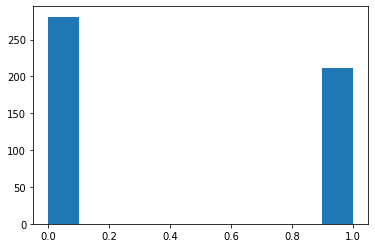

In [59]:
plt.hist(trans.loc[trans['Class']==1]['weekday'].tolist())
plt.show()

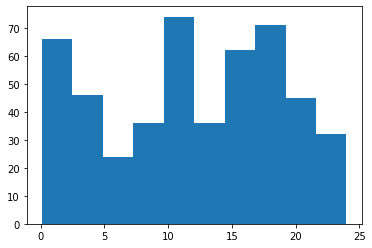

In [60]:
plt.hist(trans.loc[trans['Class']==1]['hour'].tolist())
plt.show()

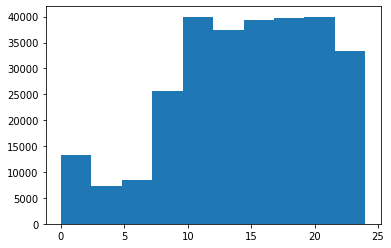

In [61]:
plt.hist(trans.loc[trans['Class']==0]['hour'].tolist())
plt.show()

In [62]:
from sklearn.utils import shuffle
trans = shuffle(trans)
trans.reset_index(drop=True, inplace=True)
trans[:5]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,weekday,hour
0,48922.0,-0.858856,1.020229,1.122091,-1.421523,0.036592,-0.784039,0.757142,-0.156908,0.694948,...,-0.040334,0.076910,-0.254924,0.767119,0.104401,-0.023476,0.92,0,0,13.589444
1,64561.0,-0.919007,0.158239,3.791503,3.401821,-0.960518,1.490213,-0.903934,0.684870,-0.080375,...,-0.198771,0.609797,0.152347,0.502720,0.152262,0.105619,49.55,0,0,17.933611
2,24182.0,-1.442688,0.976508,1.510575,-1.373680,0.192113,-0.590070,0.597776,-0.183225,1.754713,...,-0.123732,-0.028948,-0.206265,0.670641,0.374686,0.220191,34.27,0,0,6.717222
3,41034.0,1.298881,-0.649012,0.846275,-0.769185,-1.200153,-0.246700,-0.977766,0.178763,-0.791475,...,0.132533,0.209947,0.100944,-0.364609,0.031872,0.011858,5.69,0,0,11.398333
4,135719.0,-1.387120,-0.661080,-0.565709,0.210836,2.576020,3.874271,-0.869891,1.592247,-0.383677,...,0.169536,0.697986,-0.494475,-0.456639,0.145379,-0.017612,114.00,0,1,13.699722


In [63]:
# We now use the relevant features (but no Class!) to feed the autoencoder
# (We drop weekday because there are only 2 days on fata in the dataset)
AEfeed = trans.drop(['Time','Class','weekday'],axis=1)
AEfeed[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour
0,-0.858856,1.020229,1.122091,-1.421523,0.036592,-0.784039,0.757142,-0.156908,0.694948,0.285427,...,-0.147876,-0.135971,-0.040334,0.076910,-0.254924,0.767119,0.104401,-0.023476,0.92,13.589444
1,-0.919007,0.158239,3.791503,3.401821,-0.960518,1.490213,-0.903934,0.684870,-0.080375,0.284422,...,0.248271,1.015124,-0.198771,0.609797,0.152347,0.502720,0.152262,0.105619,49.55,17.933611
2,-1.442688,0.976508,1.510575,-1.373680,0.192113,-0.590070,0.597776,-0.183225,1.754713,0.217645,...,-0.372133,-0.357496,-0.123732,-0.028948,-0.206265,0.670641,0.374686,0.220191,34.27,6.717222
3,1.298881,-0.649012,0.846275,-0.769185,-1.200153,-0.246700,-0.977766,0.178763,-0.791475,0.748592,...,0.125469,0.236139,0.132533,0.209947,0.100944,-0.364609,0.031872,0.011858,5.69,11.398333
4,-1.387120,-0.661080,-0.565709,0.210836,2.576020,3.874271,-0.869891,1.592247,-0.383677,-0.492377,...,0.538036,0.871340,0.169536,0.697986,-0.494475,-0.456639,0.145379,-0.017612,114.00,13.699722


### Prepare the Data and Build an Autoencoder

In [64]:
f=len(AEfeed)
f0 = int(0.75*f)
f0

213605

In [65]:
AEfeed.shape

(284807, 30)

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(AEfeed)
# Divide in train and test:
# Important: we do not use the fake events to train and test!
X_train = scaled_seqs[:f0]  
X_test = scaled_seqs[f0:]
print(X_train.shape[1])

30


In [67]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Parameters for the auto-encoder
input_dim = X_train.shape[1] # number of features (8 in this case)

# Typical training features
nb_epoch = 30
batch_size = 128
learning_rate = 0.1

# We create the auto-encoder layer by layer:

# Create first layer that receives each scaled_seq
input_layer = Input(shape=(input_dim, ))

# Pass it to a first layer and encode
encoder = Dense(24, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(22, activation="relu")(encoder)
encoder = Dense(18, activation="relu")(encoder)
encoder = Dense(14, activation='relu')(encoder)
# start decoder
decoder = Dense(18, activation='relu')(encoder)
decoder = Dense(22, activation='relu')(decoder)
decoder = Dense(24, activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

# Physically create the auto-encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)



In [68]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                744       
_________________________________________________________________
dense_18 (Dense)             (None, 22)                550       
_________________________________________________________________
dense_19 (Dense)             (None, 18)                414       
_________________________________________________________________
dense_20 (Dense)             (None, 14)                266       
_________________________________________________________________
dense_21 (Dense)             (None, 18)                270       
_________________________________________________________________
dense_22 (Dense)             (None, 22)                418       
__________

### Fit the Model

In [69]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,   # <---- THIS IS THE *KEY* LINE THAT DEFINES THAT IS AN AUTOENCODER!
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 213605 samples, validate on 71202 samples
Epoch 1/30
213605/213605 [==============================] - 4s 17us/step - loss: 0.0171 - acc: 0.9076 - val_loss: 0.0052 - val_acc: 0.9493
Epoch 2/30
213605/213605 [==============================] - 5s 24us/step - loss: 0.0044 - acc: 0.9515 - val_loss: 0.0038 - val_acc: 0.9493
Epoch 3/30
213605/213605 [==============================] - 4s 18us/step - loss: 0.0035 - acc: 0.9517 - val_loss: 0.0031 - val_acc: 0.9494
Epoch 4/30
213605/213605 [==============================] - 4s 17us/step - loss: 0.0030 - acc: 0.9513 - val_loss: 0.0042 - val_acc: 0.9493
Epoch 5/30
213605/213605 [==============================] - 3s 16us/step - loss: 0.0027 - acc: 0.9516 - val_loss: 0.0026 - val_acc: 0.9522
Epoch 6/30
213605/213605 [==============================] - 5s 22us/step - loss: 0.0024 - acc: 0.9518 - val_loss: 0.0024 - val_acc: 0.9497
Epoch 7/30
213605/213605 [==============================] - 3s 16us/step - loss: 0.0023 - acc: 0.9519 - val_loss: 0

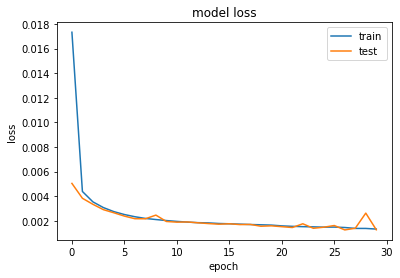

In [39]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [40]:
#autoencoder = load_model('model_seqs2.h5')
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.0013270214058695162


### Calculate the Error Term

In [41]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)

In [42]:
mse_threshold = np.quantile(mse, 0.998)
print('MSE threshold =', mse_threshold) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE threshold = 0.006302868430784555


In [43]:
scaled_seqs_scored = pd.DataFrame(scaled_seqs)

In [44]:
scaled_seqs_scored['MSE'] = mse

In [45]:
scaled_seqs_scored['MSE_Outlier'] = 0
scaled_seqs_scored.loc[scaled_seqs_scored['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [46]:
scaled_seqs_scored[:5]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,MSE,MSE_Outlier
0,0.936717,0.779513,0.869659,0.261127,0.758660,0.265814,0.258801,0.797175,0.490155,0.485649,...,0.665949,0.413118,0.534184,0.475653,0.412408,0.313427,0.000146,0.137168,0.000749,0
1,0.992563,0.763553,0.826000,0.256692,0.764653,0.264559,0.261885,0.786624,0.499739,0.508838,...,0.668921,0.236875,0.560062,0.330929,0.417087,0.312083,0.000195,0.814429,0.000315,0
2,0.940874,0.779368,0.858890,0.278303,0.767128,0.274450,0.265435,0.795058,0.447931,0.499640,...,0.661526,0.221092,0.602459,0.375845,0.420523,0.314240,0.000766,0.417348,0.000176,0
3,0.982315,0.742743,0.822806,0.229341,0.753842,0.256332,0.261337,0.783712,0.472990,0.521722,...,0.662291,0.370314,0.557062,0.409723,0.415283,0.313516,0.015686,0.692366,0.000658,0
4,0.994061,0.764443,0.804655,0.251317,0.769074,0.260535,0.265432,0.784572,0.479010,0.515610,...,0.663263,0.405991,0.599046,0.588665,0.414450,0.311259,0.000088,0.652411,0.000273,0


In [47]:
trans['MSE'] = mse

In [48]:
import math
fraud = list(map(math.log10,trans.loc[trans['Class'] == 1]['MSE'].to_list()))
legal = list(map(math.log10,trans.loc[trans['Class'] == 0]['MSE'].to_list()))

In [49]:
print(min(fraud),max(fraud),min(legal),max(legal))

-3.7428433848629017 -1.6432778840578863 -4.200806157257277 -0.6567409221877872


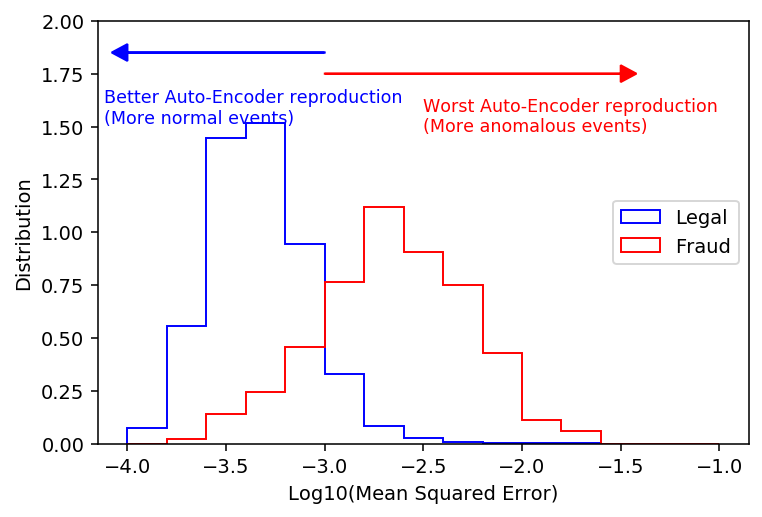

In [50]:
plt.figure(dpi=140)
plt.hist(legal,density=True,bins=15,range=(-4,-1),histtype='step',label='Legal', color='blue')
plt.hist(fraud,density=True,bins=15,range=(-4,-1),histtype='step',label='Fraud', color='red')
plt.xlabel('Log10(Mean Squared Error)')
plt.ylabel('Distribution')
plt.arrow(-3,1.75,1.5,0,head_width=0.08, head_length=0.08, color='red')
plt.arrow(-3,1.85,-1,0,head_width=0.08, head_length=0.08, color='blue')
plt.text(.5,.82,'Worst Auto-Encoder reproduction\n(More anomalous events)',ha='left',va='top', fontsize=9, color='red',transform = plt.gca().transAxes)
plt.text(.01,.84,'Better Auto-Encoder reproduction\n(More normal events)',ha='left',va='top', fontsize=9, color='blue',transform = plt.gca().transAxes)
plt.ylim(0,2)
plt.legend(loc=5)
plt.show()

## We can explore how good we can isolate fraud cases 

In [197]:
# Original fraud rate inverse
original = len(legal)/len(fraud)
threshold = -2.5
new = len(list(filter(lambda t: t>threshold, legal))) / len(list(filter(lambda t: t>threshold, fraud))) 
print('With threshold = '+str(threshold)+'\nWe pass from 1 fraud every ',round(original,1),' transaction to one fraud every ',round(new,1),' transactions')

With threshold = -2.5
We pass from 1 fraud every  577.9  transaction to one fraud every  15.0  transactions
